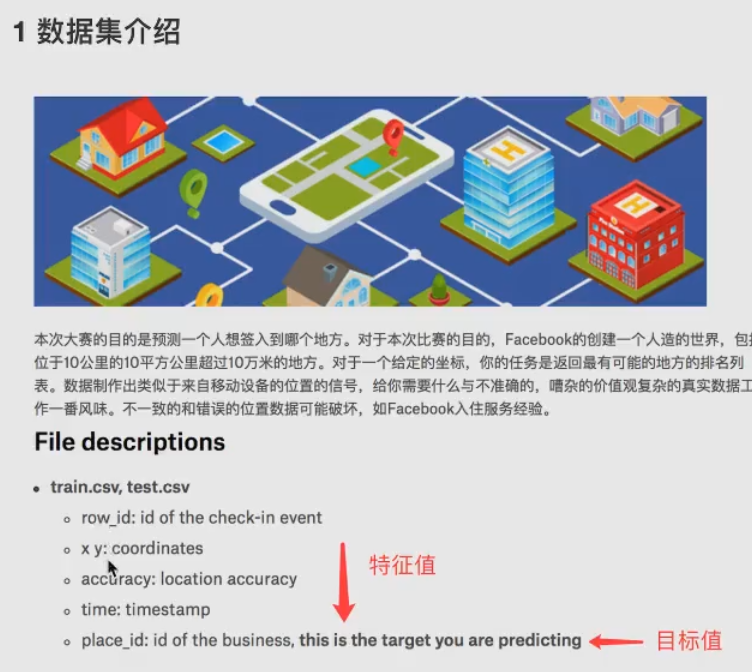

数据集网址:https://www.kaggle.com/navoshta/grid-knn/data

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

**1.获取数据**

In [2]:
data_ori = pd.read_csv('D:\codes\python_codes\machine_learning\sklearn\data\FBlocation/train.csv')

In [3]:
data = data_ori.loc[(data_ori['x']>2) & (data_ori['x']<2.5) & (data_ori['y']>1) & (data_ori['y']<1.5)]

In [4]:
data.head()

,row_id,x,y,accuracy,time,place_id
112,112,2.2360,1.3655,66,623174,7663031065
180,180,2.2003,1.2541,65,610195,2358558474
367,367,2.4108,1.3213,74,579667,6644108708
874,874,2.0822,1.1973,320,143566,3229876087
1022,1022,2.0160,1.1659,65,207993,3244363975


**2.原始数据筛选划分**

In [5]:
# 1)筛选掉签到次数少的地方
place_count = data['place_id'].value_counts()  # 只取签到次数大于10的地点,结果是Series

place_id_arr = place_count.loc[place_count.values>10].index.values

# 重要 isin()来筛选,这个方法非常好用
data = data.loc[data['place_id'].isin(place_id_arr)]

In [6]:
# 2)特征与标签的分离
x = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [7]:
# 3)数据集划分(正常情况下训练集与测试集本来就是分开的,不需要手动划分)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

3)筛选出特征值和目标值

In [8]:
x_train.head()

,row_id,x,y,accuracy,time
19141066,19141066,2.4425,1.1849,52,404316
25498837,25498837,2.2625,1.1225,19,621162
18340674,18340674,2.4198,1.1120,20,349937
8775131,8775131,2.0993,1.3217,9,33358
11906730,11906730,2.1453,1.3890,157,289910


**2.构建特征**

1)时间特征  
因为原始的数据是时间戳数字,不能直接用,所以考虑先转换成datetime,再转成DatetimeIndex
(注意:此处没做完,时间可以划分为区间,比如小时数,可以以8小时为单位划分成三个区间,然后one-hot)

*** 

(1)训练集

In [9]:
# *重要 将时间转换为日期,DatetimeIndex有很多好用的属性和方法
# 注意:不能直接将x_train['time']传进DatetimeIndex,必须先转换为datetime,再传入,不然转换的结果是错的
time_value  = pd.to_datetime(x_train['time'],unit='s')
date= pd.DatetimeIndex(time_value)

In [10]:
date

DatetimeIndex(['1970-01-05 16:18:36', '1970-01-08 04:32:42',
               '1970-01-05 01:12:17', '1970-01-01 09:15:58',
               '1970-01-04 08:31:50', '1970-01-02 01:40:56',
               '1970-01-07 04:45:04', '1970-01-09 05:10:58',
               '1970-01-08 20:41:30', '1970-01-07 03:32:15',
               ...
               '1970-01-08 10:43:25', '1970-01-03 05:19:08',
               '1970-01-05 09:12:22', '1970-01-06 05:23:43',
               '1970-01-07 13:49:32', '1970-01-06 18:28:48',
               '1970-01-08 06:05:51', '1970-01-02 20:27:54',
               '1970-01-04 19:36:54', '1970-01-01 05:10:22'],
              dtype='datetime64[ns]', name='time', length=62984, freq=None)

In [11]:
date.weekday  # .year .month .weekday .day .hour 
# 发现date.year和date.month的所有样本值相同,所以这两个不要

Int64Index([0, 3, 0, 3, 6, 4, 2, 4, 3, 2,
            ...
            3, 5, 0, 1, 2, 1, 3, 4, 6, 3],
           dtype='int64', name='time', length=62984)

In [12]:
x_train.loc[:,'weekday'] = date.weekday
x_train.loc[:,'day'] = date.day
x_train.loc[:,'hour'] = date.hour

i:\python\python36\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
i:\python\python36\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [20]:
x_train.drop(['row_id','time'],axis=1,inplace=True)

i:\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
x_train.head()

,x,y,accuracy,weekday,day,hour
19141066,2.4425,1.1849,52,0,5,16
25498837,2.2625,1.1225,19,3,8,4
18340674,2.4198,1.1120,20,0,5,1
8775131,2.0993,1.3217,9,3,1,9
11906730,2.1453,1.3890,157,6,4,8


***

(2)测试集

In [24]:
# *重要 将时间转换为日期,DatetimeIndex有很多好用的属性和方法
# 注意:不能直接将x_test['time']传进DatetimeIndex,必须先转换为datetime,再传入,不然转换的结果是错的
time_value  = pd.to_datetime(x_test['time'],unit='s')
date= pd.DatetimeIndex(time_value)

In [25]:
date

DatetimeIndex(['1970-01-05 20:54:01', '1970-01-05 18:54:20',
               '1970-01-02 03:14:04', '1970-01-01 01:46:54',
               '1970-01-09 20:46:18', '1970-01-08 08:32:07',
               '1970-01-08 00:31:46', '1970-01-01 08:05:56',
               '1970-01-09 03:18:39', '1970-01-05 00:02:27',
               ...
               '1970-01-09 02:23:42', '1970-01-09 02:50:44',
               '1970-01-02 09:14:32', '1970-01-01 10:27:38',
               '1970-01-04 18:58:31', '1970-01-05 01:00:35',
               '1970-01-01 17:11:45', '1970-01-03 16:23:19',
               '1970-01-04 14:01:42', '1970-01-02 07:08:37'],
              dtype='datetime64[ns]', name='time', length=15746, freq=None)

In [26]:
date.weekday  # .year .month .weekday .day .hour 
# 发现date.year和date.month的所有样本值相同,所以这两个不要

Int64Index([0, 0, 4, 3, 4, 3, 3, 3, 4, 0,
            ...
            4, 4, 4, 3, 6, 0, 3, 5, 6, 4],
           dtype='int64', name='time', length=15746)

In [27]:
x_test.loc[:,'weekday'] = date.weekday
x_test.loc[:,'day'] = date.day
x_test.loc[:,'hour'] = date.hour

i:\python\python36\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
i:\python\python36\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [28]:
x_test.drop(['row_id','time'],axis=1,inplace=True)

i:\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
x_test.head()

,x,y,accuracy,weekday,day,hour
8957405,2.0776,1.3397,7,0,5,20
9211285,2.3462,1.3998,75,0,5,18
116800,2.3833,1.1365,12,4,2,3
22022185,2.1488,1.0769,60,3,1,1
9939751,2.4334,1.3567,64,4,9,20


3)特征标准化

In [32]:
pro_transfer = StandardScaler()
x_train = pro_transfer.fit_transform(x_train)
x_test = pro_transfer.transform(x_test)

4)训练模型

In [33]:
estimator = KNeighborsClassifier()
param = {'n_neighbors':[1,3,5,7,9]}
estimator_grid = GridSearchCV(estimator,param_grid=param,cv=5)
estimator_grid.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [34]:
estimator_grid.score(x_test,y_test)

0.37742918836529915